In [2]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
from tensorflow import keras
import os
from time import perf_counter
import cv2
import tensorflow as tf
from keras.models import load_model
from sklearn.model_selection import train_test_split

In [3]:
def Reader(path, annotPath, size_x = 1700, size_y=2300, isPlot = False, showTime = False):
    
    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])
    
    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)

    # parsing html
    with open(annotPath, 'r') as f: 
        data = f.read() 
    
    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('x').text) + int (Bs.find('width').text)
    xMin = int (Bs.find('x').text)
    yMax = int (Bs.find('y').text)+ int (Bs.find('height').text)
    yMin = int (Bs.find('y').text) 
    #print(xMin, xMax, yMin, yMax, img.shape)
    # storing data
    dataFrame['image'].append  ( cv2.resize(img, (size_x, size_y)))
    # drawing box
    #imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0), 2)
    # storing data into frame

    x = yMin
    while x < yMax:
        y = xMin
        while y < xMax:
            img[x, y, 1] = 1
            y += 1
        x += 1
        
    dataFrame['box'].append (cv2.resize(img, (size_x, size_y)))
    
    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size_x,size_y)))
    
    if showTime:
        return perf_counter() - start

In [4]:
def Iterator(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)
    
    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)
       
    return perf_counter() - start

In [5]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

Iterator('Input/Images' ,'Input/Annotations')

12.118141299999998

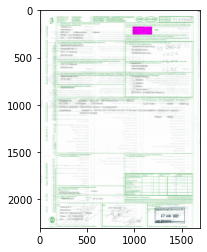

In [6]:
plt.imshow(dataFrame['box'][200])

In [7]:
def cropImages():
    y=50
    x=880
    h=768
    w=768
    
    counter = 0;
    for image in dataFrame['box']:
        dataFrame['box'][counter] = image[y:y+h, x:x+w]
        counter+=1
        
    counter = 0;
    for image in dataFrame['image']:
        dataFrame['image'][counter] = image[y:y+h, x:x+w]
        counter+=1



In [8]:
cropImages()


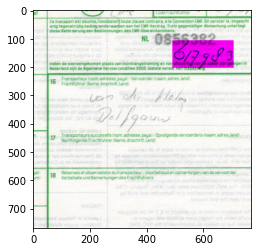

In [9]:
plt.imshow(dataFrame['box'][119])

In [10]:
# defining autoencoder model
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    
    return x

In [11]:
# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [12]:
inputs = tf.keras.layers.Input((768, 768, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
  

In [ ]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 50, verbose = 1)

Epoch 1/50
7/7 [==============================] - 944s 132s/step - loss: -36.1480 - accuracy: 0.3193
Epoch 2/50
7/7 [==============================] - 921s 130s/step - loss: -79.8867 - accuracy: 0.3121
Epoch 3/50
7/7 [==============================] - 935s 133s/step - loss: -108.4142 - accuracy: 0.3088
Epoch 4/50
7/7 [==============================] - 944s 134s/step - loss: -132.2961 - accuracy: 0.3474
Epoch 5/50
7/7 [==============================] - 907s 129s/step - loss: -152.6013 - accuracy: 0.3540
Epoch 6/50
7/7 [==============================] - 933s 133s/step - loss: -173.1089 - accuracy: 0.3664
Epoch 7/50
7/7 [==============================] - 917s 130s/step - loss: -190.7978 - accuracy: 0.3487
Epoch 8/50
7/7 [==============================] - 911s 128s/step - loss: -208.6103 - accuracy: 0.3365
Epoch 9/50
7/7 [==============================] - 917s 131s/step - loss: -225.1216 - accuracy: 0.3452
Epoch 10/50
7/7 [==============================] - 942s 134s/step - loss: -242.7102 